In [19]:
import os
import numpy as np
import torch
from noise2noise.datasets import load_dataset
from noise2noise.noise2noise import Noise2Noise
from noise2noise.utils import create_montage
from argparse import Namespace
from PIL import Image
import torchvision.transforms as transforms
import torchvision.transforms.functional as tvF

import matplotlib.pyplot as plt

%matplotlib inline



In [6]:
class Args:
    test_image = 'noise2noise/data/test/volumeWithArtifacts_YZ.png'
    clean_image = 'noise2noise/data/GT/volumeWithBH_YZ.png'  # Optional: Path to ground truth clean image
    load_ckpt = 'ckpts/gaussian/n2n-gaussian.pt'
    show_output = 2
    cuda = torch.cuda.is_available()
    noise_type = 'gaussian'
    noise_param = 50
    seed = None
    crop_size = 256
    no_crop = True
    add_noise = False

params = Args()


In [7]:
# Function to load and preprocess the test image
def load_test_image(image_path, crop_size, no_crop):
    """Loads and preprocesses the test image."""
    img = Image.open(image_path).convert('RGB')

    if not no_crop and crop_size > 0:
        # Center crop if no_crop is not set
        transform = transforms.Compose([
            transforms.CenterCrop(crop_size),
            transforms.ToTensor()
        ])
    else:
        # Just convert to tensor
        transform = transforms.Compose([
            transforms.ToTensor()
        ])

    img_tensor = transform(img).unsqueeze(0)  # Add batch dimension
    return img_tensor

In [11]:
# Initialize model and load checkpoint
n2n = Noise2Noise(params, trainable=False)
n2n.load_model(params.load_ckpt)

# Load the test image
test_image = load_test_image(params.test_image, params.crop_size, params.no_crop)

# Load the clean (ground truth) image if provided
clean_image = None
if params.clean_image:
    clean_image = load_test_image(params.clean_image, params.crop_size, params.no_crop)


Noise2Noise: Learning Image Restoration without Clean Data (Lethinen et al., 2018)
Loading checkpoint from: ckpts/gaussian/n2n-gaussian.pt


In [12]:
# Move the test image to GPU if available
if params.cuda and torch.cuda.is_available():
    test_image = test_image.cuda()
    if clean_image is not None:
        clean_image = clean_image.cuda()

In [13]:
# Denoise the image
n2n.model.eval()
with torch.no_grad():
    denoised_image = n2n.model(test_image).cpu().squeeze()

In [16]:
def psnr(input, target):
    """Computes peak signal-to-noise ratio."""
    input_np = input.detach().cpu().numpy()
    target_np = target.detach().cpu().numpy()
    mse = np.mean((input_np - target_np) ** 2)
    if mse == 0:
        return 100
    PIXEL_MAX = 255.0
    return 20 * np.log10(PIXEL_MAX / np.sqrt(mse))

def create_montage(img_name, noise_type, save_path, source_img, denoised_img, clean_img=None, show=0):
    """Creates and displays montage for easy comparison."""
    if clean_img is not None:
        fig, ax = plt.subplots(2, 3, figsize=(15, 10))
    else:
        fig, ax = plt.subplots(2, 2, figsize=(10, 10))

    # Build image montage
    titles = ['Input', 'Denoised']
    images = [source_img, denoised_img]
    psnr_vals = []

    if clean_img is not None:
        titles.append('Ground Truth')
        images.append(clean_img)
        psnr_vals.append(psnr(clean_img, denoised_img))
        titles[1] += f': {psnr_vals[-1]:.2f} dB'

    plot_data_list = []
    min_y = []
    max_y = []

    for j, (title, img) in enumerate(zip(titles, images)):
        ax[0][j].imshow(img)
        ax[0][j].axhline(y=img.size[1] // 2, color='red', lw=2, ls='-')
        ax[0][j].set_title(title)
        ax[0][j].axis('off')

        img_array = np.array(img)
        plot_data = img_array[img.size[1] // 2]
        plot_data_list.append(plot_data)
        min_y.append(plot_data.min())
        max_y.append(plot_data.max())

    global_min_y = min(min_y)
    global_max_y = max(max_y)

    for j in range(len(plot_data_list)):
        ax[1][j].plot(plot_data_list[j], lw=1, ls='-', color='red')
        ax[1][j].set_ylim(global_min_y, global_max_y)
        ax[1][j].axis('on')

    if clean_img is not None:
        ax[0][2].imshow(clean_img)
        ax[0][2].axhline(y=clean_img.size[1] // 2, color='red', lw=2, ls='-')
        ax[0][2].set_title('Ground Truth')
        ax[0][2].axis('off')

        clean_array = np.array(clean_img)
        clean_data = clean_array[clean_img.size[1] // 2]
        ax[1][2].plot(clean_data, lw=1, ls='-', color='red')
        ax[1][2].set_ylim(global_min_y, global_max_y)
        ax[1][2].axis('on')

    plt.tight_layout()

    fname = os.path.splitext(img_name)[0]
    source_img.save(os.path.join(save_path, f'{fname}-{noise_type}-noisy.png'))
    denoised_img.save(os.path.join(save_path, f'{fname}-{noise_type}-denoised.png'))
    if clean_img is not None:
        clean_img.save(os.path.join(save_path, f'{fname}-{noise_type}-clean.png'))
    fig.savefig(os.path.join(save_path, f'{fname}-{noise_type}-montage.png'), bbox_inches='tight')
    plt.show()

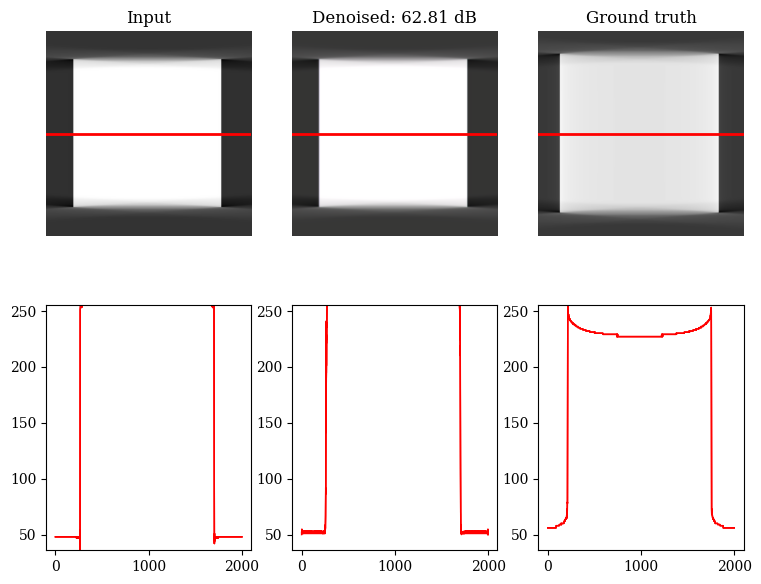

In [20]:
# Create and save the montage
create_montage(
    img_name=os.path.basename(params.test_image),
    noise_type=params.noise_type,
    save_path=os.path.dirname(params.test_image),
    source_t=test_image.squeeze(),
    denoised_t=denoised_image,
    clean_t=clean_image.squeeze() if clean_image is not None else None,
    show=params.show_output
)

tensor(1.0369)